# Optimize metadata features
We will analyze the effect of metadata features on the MAE performance of the baseline model. We will use the baseline model (RF with default/unopitimized hyper-parameters) and binary encoded genetic difference. The selection of features will be based on the performance of model over four validation seasons from 2012NH to 2013SH.

## Imports

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import utilities   # self defined functions
import model_utilities   # self defined models
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder

# (for reproduciblility) fix the randomly generated numbers
SEED = 100
np.random.seed(SEED)

## Variables

In [3]:
mut_mat       = "binary"   # mutation matrix
Valid_Seasons = ['2012NH', '2012SH', '2013NH', '2013SH'] # seasons from 2012NH to 2013SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 # 'virus',   # virus avidity
                 'serum',   # antiserum potency
                 # 'virusPassCat',
                 # 'serumPassCat'
                 ]   # metadata features

metadata   = 'antiserum potency (p)'   # label to record which metadata is being used
model_name = 'baseline'   # the type of model to be used

## Paths and filenames

In [4]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/SuppFig3_optimization_RFmodel/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn  = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
train_fn = path_result + "SuppFig3a_optimize_metadata_trainScores.csv"   # to save performance scores for training dataset
valid_fn = path_result + "SuppFig3a_optimize_metadata_validScores.csv"   # to save performance scores for validation dataset
fig_fn   = path_result + "SuppFig3a_optimize_metadata_MAE_barplot.svg"   # to save figure

## Read data
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [ ]:
data = pd.read_csv(data_fn, converters={"seq_diff": literal_eval})

## Performance of the model
- For each validation season from 2012NH to 2013SH
    - Split the data into training and validation datasets
    - Prepare encoded inputs (genetic difference and metadata features)
    - Train and validate the model
    - Compute predictive performance
    - Save the predictions
- Compute average predictive performance

In [ ]:
# to collect actuals and predictions for micro-averaged scores over all seasons
actual_train_all  = {}
predict_train_all = {}

actual_valid_all  = {}
predict_valid_all = {}


# loop through validation seasons
for valid_season in Valid_Seasons:
    print("Validation Season: ", valid_season)

    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_valid = utilities.seasonal_trainTestSplit(data.copy(), valid_season)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # validation dataset
    data_valid = data.iloc[ind_valid].copy()
    data_valid.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # validation dataset
    X_valid = pd.DataFrame(data_valid.seq_diff.to_list(),
                           index=data_valid.index,
                           columns=HA1_features)
    X_valid.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_valid_meta = data_valid[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_valid_meta = ohe.transform(X_valid_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_valid = np.hstack((X_valid.values, X_valid_meta))


    del X_train_meta, X_valid_meta
        
    
    '''
    Training and validation
    '''
    # baseline model
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    data_train.nht.values,
                    X_test = X_valid)
    
    
    '''
    Training Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'season']
    col_values = [mut_mat, model_name, metadata, valid_season]
    utilities.compute_scores(data_train.nht.values, results['pred_train'], train_fn, col=cols, col_val=col_values)
    
    
    '''
    Validation Scores
    '''
    utilities.compute_scores(data_valid.nht.values, results['pred_test'], valid_fn, col=cols, col_val=col_values)
    
    
    '''
    Save actuals and predictions
    '''
    actual_train_all[f'{valid_season}']  = data_train.nht.values
    predict_train_all[f'{valid_season}'] = results['pred_train']
    
    actual_valid_all[f'{valid_season}']  = data_valid.nht.values
    predict_valid_all[f'{valid_season}'] = results['pred_test']
    
    #################
    # End season loop
    #################


'''
Micro-average over seasons
'''
actual_train  = np.concatenate(list(actual_train_all.values()))
predict_train = np.concatenate(list(predict_train_all.values()))

actual_valid  = np.concatenate(list(actual_valid_all.values()))
predict_valid = np.concatenate(list(predict_valid_all.values()))


# Training scores
col_values = [mut_mat, model_name, metadata, 'Average']
utilities.compute_scores(actual_train, predict_train, train_fn, col=cols, col_val=col_values)


# Validation scores
utilities.compute_scores(actual_valid, predict_valid, valid_fn, col=cols, col_val=col_values)

print("Training and testing completed")

## Repeat for different metadata features
Repeat the code cells first under heading "Variables" and then "Performance of the model" for following values of the variables "meta_features", and "metadata":
- **meta_features**=['virus'], **metadata**="virus avidity (a)"
- **meta_features**=['serum'], **metadata**="antiserum potency (p)"
- **meta_features**=['virusPassCat'], **metadata**="virus passage category (vPC)"
- **meta_features**=['serumPassCat'], **metadata**="antiserum PC (sPC)"
- **meta_features**=['virus', 'serum'], **metadata**="a+p"
- **meta_features**=['virusPassCat', 'serumPassCat'], **metadata**="vPC+sPC"
- **meta_features**=['virus', ''virusPassCat], **metadata**="a+vPC"
- **meta_features**=['serum', ''serumPassCat], **metadata**="p+sPC"
- **meta_features**=['virus', 'serum', 'virusPassCat', 'serumPassCat'], **metadata**="a+p+vPC+sPC"

## Imports and configuration for plotting

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={"axes.labelsize":9,
                    "xtick.labelsize":8,
                    "ytick.labelsize":8,
                    "legend.fontsize":8,
                    "legend.title_fontsize":8})

## Read validation scores and prepare data for plots

In [6]:
scores = pd.read_csv(valid_fn)
scores = scores[(scores.season=="Average")]
scores.drop(columns=['mut_mat', 'model', 'season'], inplace=True)

## Plot average MAE per metadata

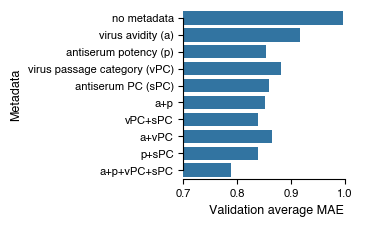

In [7]:
fig, ax = plt.subplots(figsize=(2.4,2.2))

plot = sns.barplot(x='MAE', y='metadata', data=scores,
                   color="C0",
                   ax=ax)

# configurations for figure
ax.set_ylabel("Metadata", fontsize=9)
ax.set_xlabel("Validation average MAE", fontsize=9)
ax.set_xlim(left=0.7)

sns.despine(trim=True)

# save figure
fig.savefig(fig_fn, format='svg', bbox_inches='tight')